<a href="https://colab.research.google.com/github/kaluznys/uczenie_maszynowe_UW/blob/main/praca_9_um.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


In [7]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)   # First layer: 784 → 128
        self.fc2 = nn.Linear(128, 64)        # Second layer: 128 → 64
        self.fc3 = nn.Linear(64, 10)         # Output layer: 64 → 10 (digits)

    def forward(self, x):
        x = x.view(-1, 28 * 28)              # Flatten image to 1D vector
        x = F.relu(self.fc1(x))              # Apply ReLU after first layer
        x = F.relu(self.fc2(x))              # ReLU again
        x = self.fc3(x)                      # Final raw scores (logits)
        return x

In [ ]:

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

In [4]:
transform = transforms.Compose(
    [ transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      transforms.Normalize((0.1307), (0.3081))])

trainset = datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.78MB/s]


In [5]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)


for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i==0:
            print(i, "-th batch inputs :", batch_inputs)
            batch_inputs.to(device)
            batch_labels.to(device)

0 -th batch labels : tensor([4, 3, 4,  ..., 8, 2, 7])
1 -th batch labels : tensor([1, 0, 8,  ..., 7, 1, 1])
2 -th batch labels : tensor([2, 6, 4,  ..., 0, 5, 3])
3 -th batch labels : tensor([9, 9, 2,  ..., 6, 2, 0])
4 -th batch labels : tensor([3, 3, 5,  ..., 1, 7, 3])
0 -th batch inputs : tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242

In [8]:

print(device)
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

model.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(2):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = model(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

cuda
epoch: 0 batch: 0 current batch loss: 2.3093130588531494
epoch: 0 batch: 1 current batch loss: 2.2363603115081787
epoch: 0 batch: 2 current batch loss: 2.1592750549316406
epoch: 0 batch: 3 current batch loss: 2.070549249649048
epoch: 0 batch: 4 current batch loss: 1.9789456129074097
epoch: 0 batch: 5 current batch loss: 1.8747926950454712
epoch: 0 batch: 6 current batch loss: 1.7499332427978516
epoch: 0 batch: 7 current batch loss: 1.63955557346344
epoch: 0 batch: 8 current batch loss: 1.52848219871521
epoch: 0 batch: 9 current batch loss: 1.410570740699768
epoch: 0 batch: 10 current batch loss: 1.2913415431976318
epoch: 0 batch: 11 current batch loss: 1.1681160926818848
epoch: 0 batch: 12 current batch loss: 1.0703091621398926
epoch: 0 batch: 13 current batch loss: 0.9587609171867371
epoch: 0 batch: 14 current batch loss: 0.8930104374885559
epoch: 0 batch: 15 current batch loss: 0.7953090071678162
epoch: 0 batch: 16 current batch loss: 0.7597342133522034
epoch: 0 batch: 17 curren

In [9]:
num_steps =300
lr = 0.05
target_labels = torch.arange(10, device=device)  # digits 0-9
dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

optimizer = torch.optim.Adam([dreamed_images], lr=lr)
loss_fn = nn.CrossEntropyLoss()

history = []
image_snapshots = []

for step in range(num_steps):
    optimizer.zero_grad()
    output = model(dreamed_images)
    loss = loss_fn(output, target_labels)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        probs = F.softmax(output, dim=1)
        confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
        history.append(confidence)

    if step % 50 == 0 or step == num_steps - 1:
        print(f"Step {step} | Loss: {loss.item():.4f} | Mean confidence: {np.mean(confidence):.4f}")
        snapshot = dreamed_images.clone().detach().cpu()
        image_snapshots.append(snapshot)

dreamed_images, confidence_history = dreamed_images.detach(), np.array(history)

Step 0 | Loss: 2.5321 | Mean confidence: 0.0869
Step 50 | Loss: 0.0003 | Mean confidence: 0.9997
Step 100 | Loss: 0.0003 | Mean confidence: 0.9997
Step 150 | Loss: 0.0002 | Mean confidence: 0.9998
Step 200 | Loss: 0.0002 | Mean confidence: 0.9998
Step 250 | Loss: 0.0002 | Mean confidence: 0.9998
Step 299 | Loss: 0.0001 | Mean confidence: 0.9999


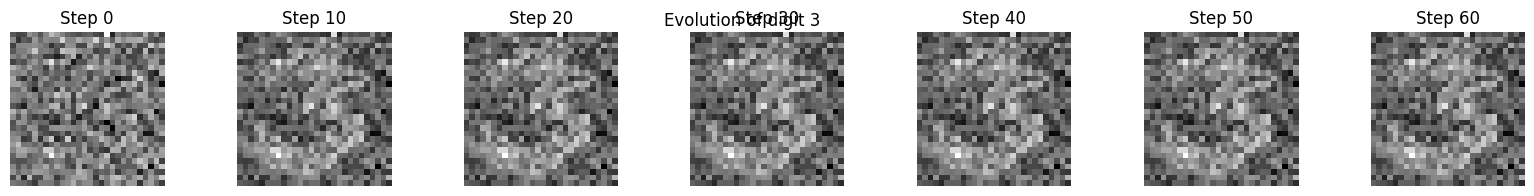

In [10]:
digit_idx = 3  # index from 0 to 9

fig, axes = plt.subplots(1, len(image_snapshots), figsize=(20, 2))
for i, snapshot in enumerate(image_snapshots):
    img = snapshot[digit_idx].squeeze()
    img = (img - img.min()) / (img.max() - img.min())  # normalize
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Step {i*10}")
plt.suptitle(f"Evolution of digit {digit_idx}")
plt.show()

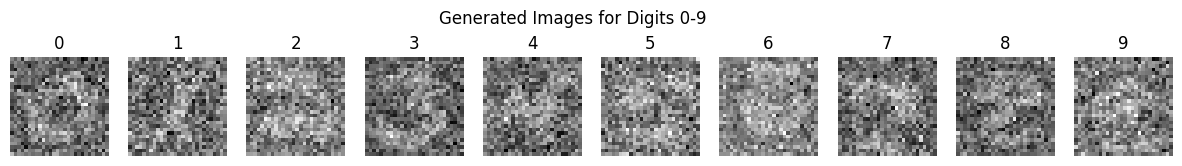

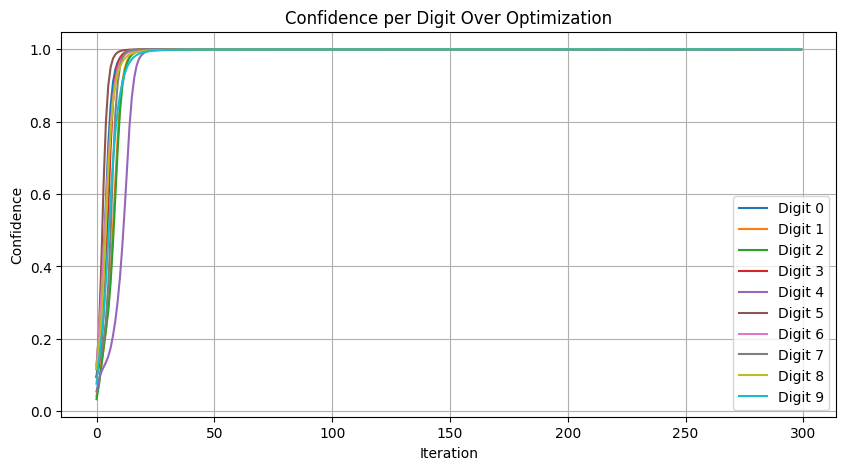

In [11]:
def plot_results(images, confidence_history):
    images = images.cpu().numpy().squeeze()

    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(images[i], cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(str(i))
    plt.suptitle("Generated Images for Digits 0-9")
    plt.show()

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(confidence_history[:, i], label=f"Digit {i}")
    plt.xlabel("Iteration")
    plt.ylabel("Confidence")
    plt.title("Confidence per Digit Over Optimization")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution
model.to(device)
model.eval()
plot_results(dreamed_images, confidence_history)

# Task 2

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define pairs of digits to simulate
digit_pairs = []
for i in range(7):
    for j in range(i+3, 10):
        digit_pairs.append((i, j))

def dream_dual_digits(model, num_steps=300, lr=0.05):
    dreamed_images = torch.randn((len(digit_pairs), 1, 28, 28), device=device, requires_grad=True)
    optimizer = torch.optim.Adam([dreamed_images], lr=lr)
    history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(dreamed_images)  # shape: [5, 10]
        probs = F.softmax(output, dim=1)

        # Create loss to boost confidence in BOTH target digits
        losses = []
        for i, (digit1, digit2) in enumerate(digit_pairs):
            loss1 = -torch.log(probs[i, digit1] + 1e-8)
            loss2 = -torch.log(probs[i, digit2] + 1e-8)
            losses.append((loss1 + loss2) / 2)
        loss = torch.stack(losses).mean()

        loss.backward()
        optimizer.step()

        # Log mean confidence in both targets
        with torch.no_grad():
            confidence = torch.tensor([
                (probs[i, d1] + probs[i, d2])
                for i, (d1, d2) in enumerate(digit_pairs)
            ])
            history.append(confidence.cpu().numpy())

        if step % 50 == 0 or step == num_steps - 1:
            print(f"Step {step} | Loss: {loss.item():.4f} | Mean confidence: {confidence.mean().item():.4f}")

    return dreamed_images.detach().cpu(), np.array(history)

# Plotting function
def plot_results(images, history, digit_pairs):
    fig, axes = plt.subplots(1, len(images), figsize=(150, 30))
    for i, ax in enumerate(axes):
        ax.imshow(images[i][0], cmap="gray")
        ax.axis("off")
        ax.set_title(f"{digit_pairs[i][0]} & {digit_pairs[i][1]}")
    plt.suptitle("Dreamed Images for Digit Pairs")
    plt.show()

    # Plot confidence evolution
    history = np.array(history)
    plt.figure(figsize=(10, 5))
    for i, (d1, d2) in enumerate(digit_pairs):
        plt.plot(history[:, i], label=f"{d1}&{d2}")
    plt.title("Confidence in Target Digit Pairs over Time")
    plt.xlabel("Step")
    plt.ylabel("Mean Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()


Step 0 | Loss: 5.4628 | Mean confidence: 0.1994
Step 50 | Loss: 0.6960 | Mean confidence: 0.9983
Step 100 | Loss: 0.6940 | Mean confidence: 0.9991
Step 150 | Loss: 0.6937 | Mean confidence: 0.9994
Step 200 | Loss: 0.6936 | Mean confidence: 0.9996
Step 250 | Loss: 0.6935 | Mean confidence: 0.9997
Step 299 | Loss: 0.6934 | Mean confidence: 0.9997


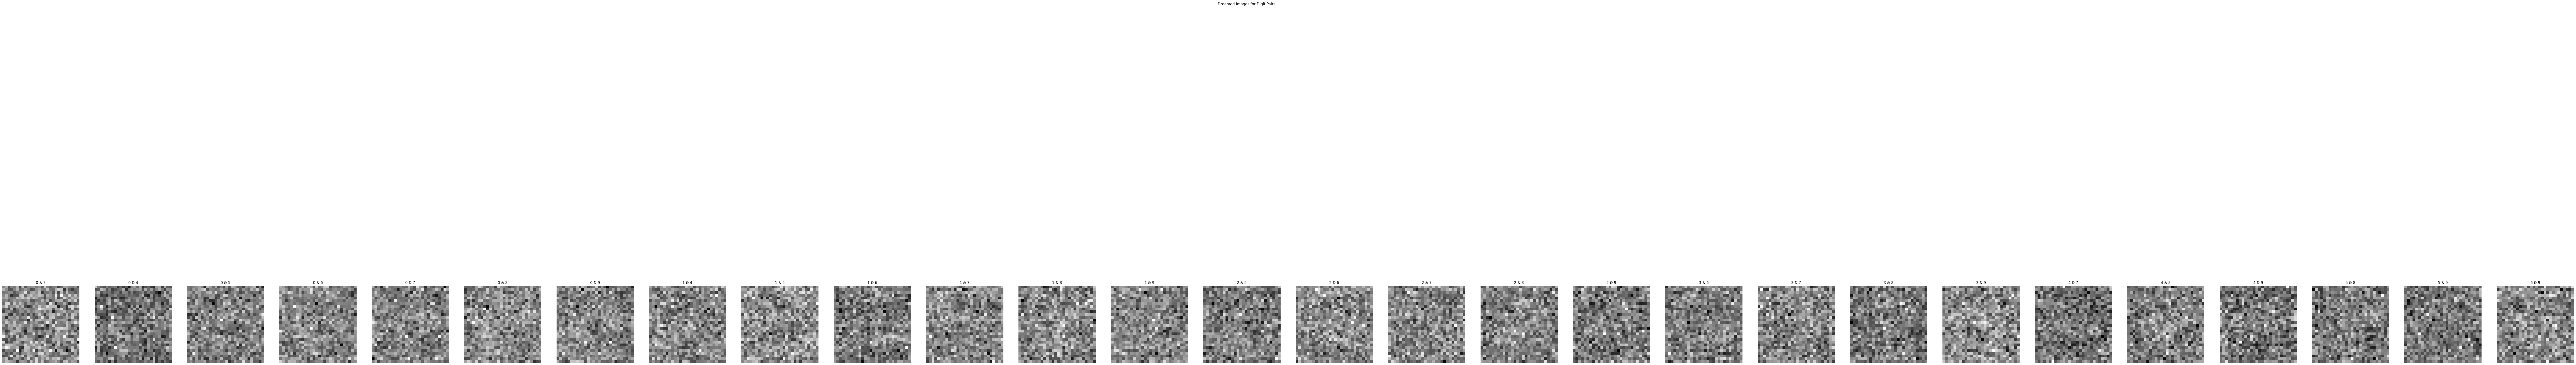

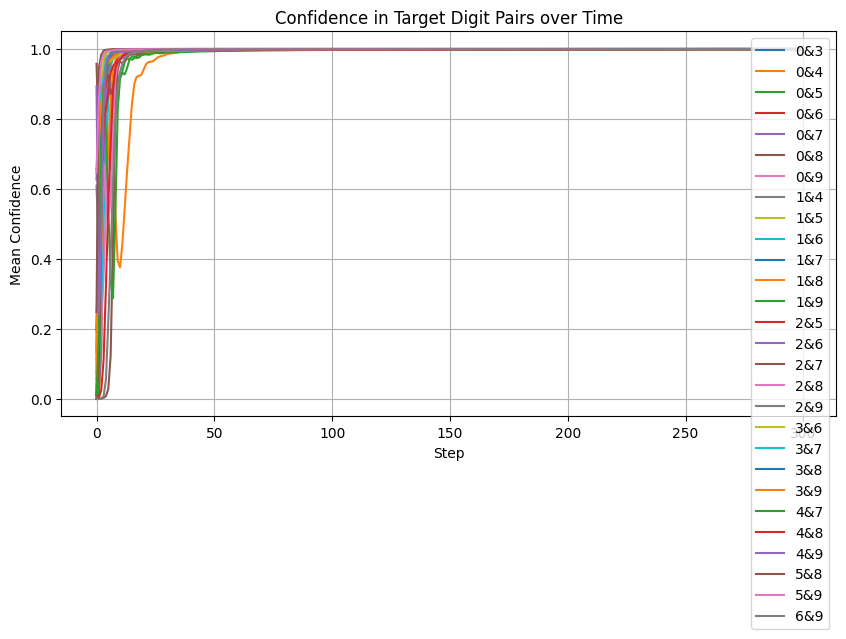

In [ ]:
# Call the function using your pretrained model
dreamed_images, history = dream_dual_digits(model)

# Visualize the images and confidence progression
plot_results(dreamed_images, history, digit_pairs)

# task 3

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
F.softmax  # just so it's clear where it comes from

def dream_digits_l2(model, num_steps=300, lr=0.1, lambda_l2=1.0):
    target_labels = torch.arange(10, device=device)  # digits 0-9
    dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

    optimizer = torch.optim.Adam([dreamed_images], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(dreamed_images)
        ce_loss = loss_fn(output, target_labels)

        # L2 penalty term (squared pixel values)
        l2_penalty = dreamed_images.pow(2).mean()
        loss = ce_loss + lambda_l2 * l2_penalty

        loss.backward()
        optimizer.step()

        # Evaluate confidence
        with torch.no_grad():
            probs = F.softmax(output, dim=1)
            confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
            history.append(confidence)

        if step % 50 == 0 or step == num_steps - 1:
            print(f"Step {step} | CE Loss: {ce_loss.item():.4f} | L2: {l2_penalty.item():.4f} | Mean Conf: {np.mean(confidence):.4f}")

    final_images = dreamed_images.clone().detach().cpu().squeeze()
    return final_images, np.array(history)

In [ ]:
def plot_task3_results(images, history):
    # Plot final generated digits
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
        ax.set_title(f"Digit {i}")
    plt.suptitle("Dreamed Digits with L2 Regularization")
    plt.show()

    # Plot confidence evolution
    history = np.array(history)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(history[:, i], label=f"{i}")
    plt.title("Classification Confidence Over Time")
    plt.xlabel("Step")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
final_images, confidence_history = dream_digits_l2(model, lambda_l2=1)

Step 0 | CE Loss: 5.8961 | L2: 1.0114 | Mean Conf: 0.0194
Step 50 | CE Loss: 0.0002 | L2: 0.3726 | Mean Conf: 0.9998
Step 100 | CE Loss: 0.0018 | L2: 0.0837 | Mean Conf: 0.9982
Step 150 | CE Loss: 0.0025 | L2: 0.0269 | Mean Conf: 0.9975
Step 200 | CE Loss: 0.0026 | L2: 0.0143 | Mean Conf: 0.9974
Step 250 | CE Loss: 0.0026 | L2: 0.0112 | Mean Conf: 0.9974
Step 299 | CE Loss: 0.0026 | L2: 0.0105 | Mean Conf: 0.9974


Step 0 | CE Loss: 5.9547 | L2: 1.0220 | Mean Conf: 0.0588
Step 50 | CE Loss: 0.0000 | L2: 1.3642 | Mean Conf: 1.0000
Step 100 | CE Loss: 0.0000 | L2: 1.3036 | Mean Conf: 1.0000
Step 150 | CE Loss: 0.0000 | L2: 1.2317 | Mean Conf: 1.0000
Step 200 | CE Loss: 0.0000 | L2: 1.1588 | Mean Conf: 1.0000
Step 250 | CE Loss: 0.0000 | L2: 1.0867 | Mean Conf: 1.0000
Step 299 | CE Loss: 0.0000 | L2: 1.0179 | Mean Conf: 1.0000


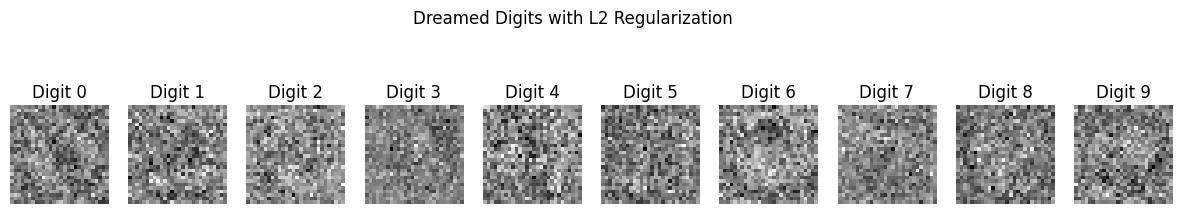

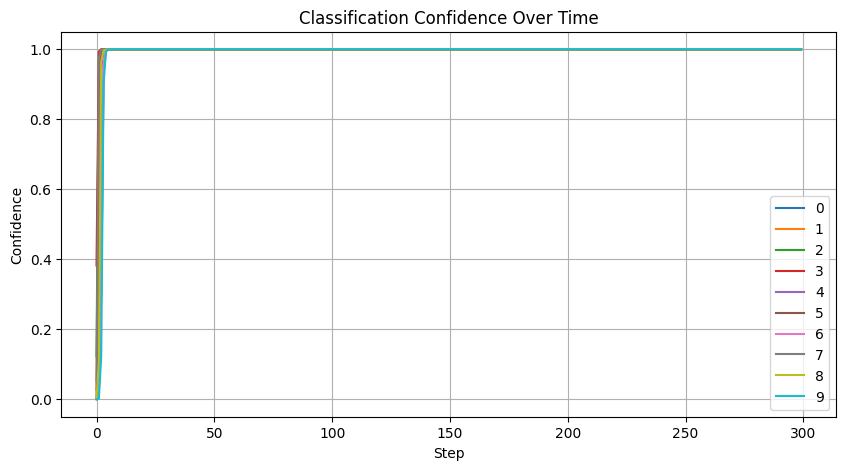

Step 0 | CE Loss: 3.9302 | L2: 1.0056 | Mean Conf: 0.1493
Step 50 | CE Loss: 0.0000 | L2: 1.0096 | Mean Conf: 1.0000
Step 100 | CE Loss: 0.0000 | L2: 0.7176 | Mean Conf: 1.0000
Step 150 | CE Loss: 0.0000 | L2: 0.5111 | Mean Conf: 1.0000
Step 200 | CE Loss: 0.0001 | L2: 0.3661 | Mean Conf: 0.9999
Step 250 | CE Loss: 0.0001 | L2: 0.2641 | Mean Conf: 0.9999
Step 299 | CE Loss: 0.0002 | L2: 0.1934 | Mean Conf: 0.9998


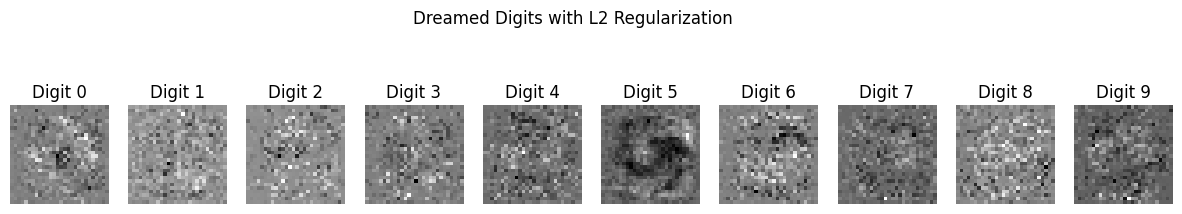

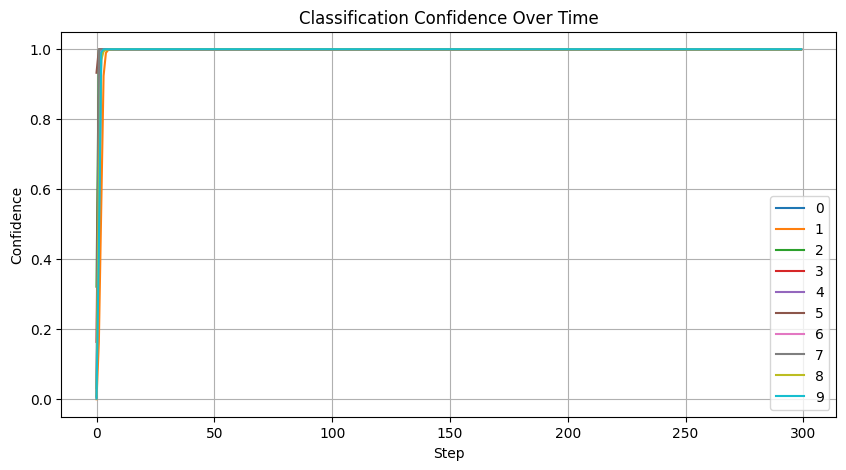

Step 0 | CE Loss: 3.1012 | L2: 1.0086 | Mean Conf: 0.2109
Step 50 | CE Loss: 0.0005 | L2: 0.2583 | Mean Conf: 0.9995
Step 100 | CE Loss: 0.0023 | L2: 0.0517 | Mean Conf: 0.9977
Step 150 | CE Loss: 0.0026 | L2: 0.0182 | Mean Conf: 0.9974
Step 200 | CE Loss: 0.0026 | L2: 0.0119 | Mean Conf: 0.9974
Step 250 | CE Loss: 0.0026 | L2: 0.0106 | Mean Conf: 0.9974
Step 299 | CE Loss: 0.0026 | L2: 0.0103 | Mean Conf: 0.9974


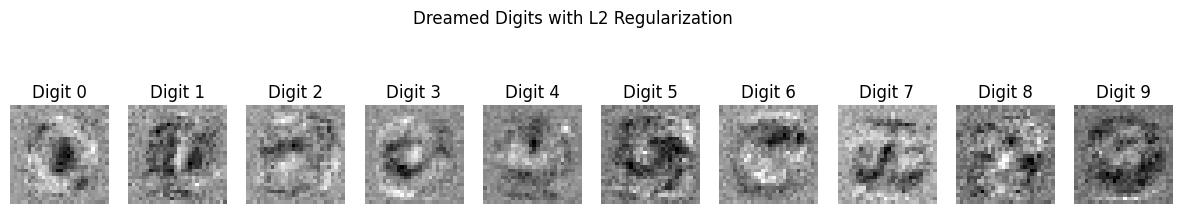

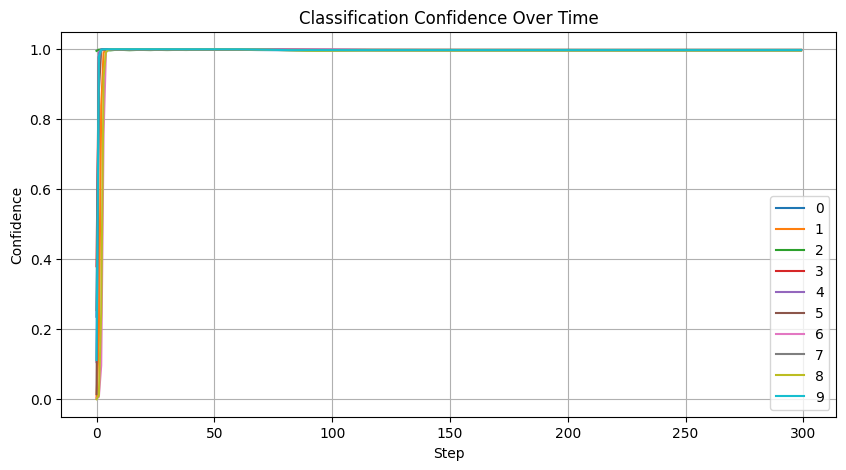

Step 0 | CE Loss: 4.3249 | L2: 0.9967 | Mean Conf: 0.2122
Step 50 | CE Loss: 0.0194 | L2: 0.0107 | Mean Conf: 0.9808
Step 100 | CE Loss: 0.0193 | L2: 0.0057 | Mean Conf: 0.9809
Step 150 | CE Loss: 0.0192 | L2: 0.0057 | Mean Conf: 0.9810
Step 200 | CE Loss: 0.0192 | L2: 0.0056 | Mean Conf: 0.9810
Step 250 | CE Loss: 0.0192 | L2: 0.0056 | Mean Conf: 0.9810
Step 299 | CE Loss: 0.0193 | L2: 0.0056 | Mean Conf: 0.9809


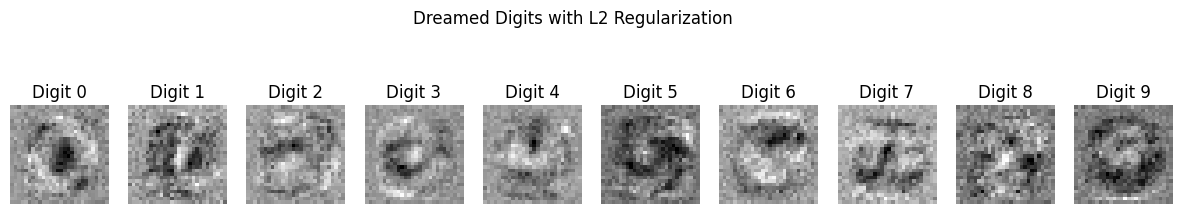

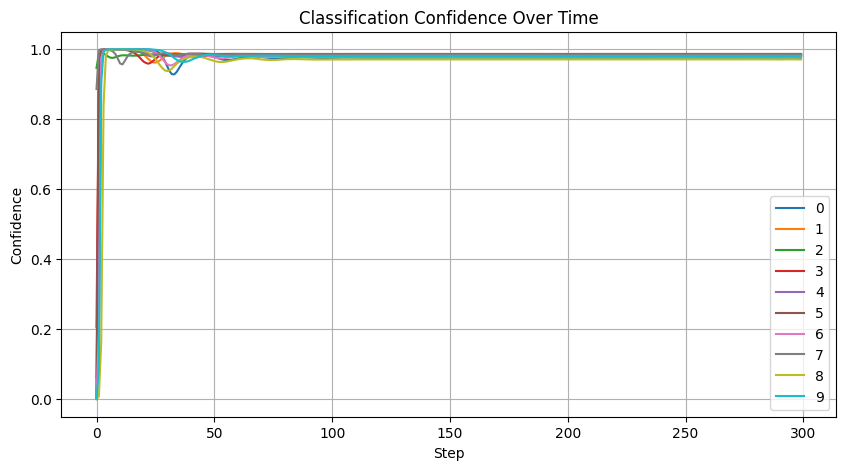

Step 0 | CE Loss: 3.5218 | L2: 0.9998 | Mean Conf: 0.0808
Step 50 | CE Loss: 0.1358 | L2: 0.0049 | Mean Conf: 0.8734
Step 100 | CE Loss: 0.1336 | L2: 0.0025 | Mean Conf: 0.8754
Step 150 | CE Loss: 0.1335 | L2: 0.0025 | Mean Conf: 0.8755
Step 200 | CE Loss: 0.1331 | L2: 0.0025 | Mean Conf: 0.8758
Step 250 | CE Loss: 0.1337 | L2: 0.0025 | Mean Conf: 0.8753
Step 299 | CE Loss: 0.1335 | L2: 0.0025 | Mean Conf: 0.8754


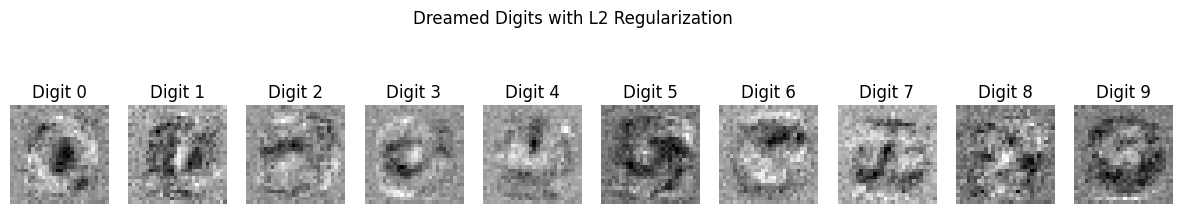

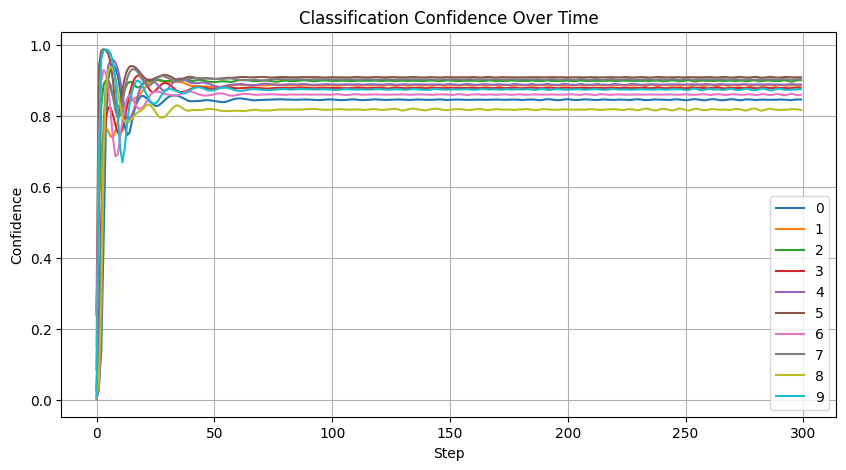

In [ ]:
for lam in [0.01, 0.1, 1, 10, 100]:
  final_images, confidence_history = dream_digits_l2(model, lambda_l2=lam)

  # Visualize
  plot_task3_results(final_images, confidence_history)